## 의사결정나무

### 01 라이브러리, 하이퍼파라미터 정의

#### 01-01 라이브러리, 데이터부르기

In [ ]:
import numpy as np
import pandas as pd
import graphviz # decision tree 시각화
import pydotplus
import matplotlib.pyplot as plt

from sklearn import tree, model_selection
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

base_path = '/content/drive/MyDrive/AI_serivce_track/Week_02'

# 정확한 이름으로 다시 할당
classification_data_path = os.path.join(base_path, 'diabetes.csv')


In [ ]:

classification_feature_names = [
    "pregnant",  # 임신 횟수
    "glucose",  # 혈당 수치
    "bp",  # 혈압
    "skin",  # 피부 두께
    "insulin",  # 인슐린 수치
    "bmi",  # 체질량 지수
    "pedigree",  # 당뇨병 가족력
    "age",  # 나이
    "label",  # 당뇨병 여부 (0: 없음, 1: 있음)
]

regression_data_info = fetch_california_housing()
regression_feature_names = regression_data_info.feature_names

test_data_ratio = 0.3
random_state = 0

max_depth = 3
min_sample_leaf = 3

### 02 함수 불러오는 class 정의
- 근데 데이터 불러올 때 굳이 class를 정의할까 하는 생각도 했었다.
  - 아마 여러 개의 데이터를 불러올 때의 재사용성 때문에 정의하는게 아닐런지.

In [ ]:
class RegressionDataLoader:
  def __init__(self, data_info, feature_names, test_data_ratio, random_state):
    self.data_info = data_info
    self.feature_names = feature_names
    self.test_data_ratio = test_data_ratio
    self.random_state = random_state

    self.data_infos = self.get_data_infos()
    self.data, self.label = self.get_dataset()

    self.train_data, self.train_label, self.test_data, self.test_label = self.get_split_data()


  def __call__(self, flag):
    if flag == 'train':
        return self.train_data, self.train_label
    else:
        return self.test_data, self.test_label

  def get_data_infos(self):
    df = pd.DataFrame(self.data_info.data, columns=self.feature_names)
    df['label'] = self.data_info.target

    return df

  def get_dataset(self):
    data, label = self.data_infos.drop(columns=['label']), self.data_infos['label']

    return data, label

  def get_split_data(self):
    train_data, test_data, train_label, test_label = model_selection.train_test_split(
        self.data, self.label, test_size=self.test_data_ratio, random_state = self.random_state
    )
    return train_data, train_label, test_data, test_label


regression_dataloader = RegressionDataLoader(regression_data_info, regression_feature_names, test_data_ratio, random_state)
regression_train_data, regression_train_label = regression_dataloader('train')
regression_test_data, regression_test_label = regression_dataloader('test')

print('regression train data: {}/regression train label: {}'.format(regression_train_data.shape, regression_train_label.shape))
print('regression test data: {}/regressiontest label: {}'.format(regression_test_data.shape, regression_test_label.shape))

regression train data: (14448, 8)/regression train label: (14448,)
regression test data: (6192, 8)/regressiontest label: (6192,)


### 03 DecisionTree - 회귀(값)

In [ ]:
class SklearnDecisionTreeRegressor:
    def __init__(self, feature_names, max_depth, min_sample_leaf, random_state):
        self.feature_names = feature_names
        self.max_depth = max_depth
        self.min_sample_leaf = min_sample_leaf
        self.random_state = random_state

        self.regressor = tree.DecisionTreeRegressor(
            max_depth=self.max_depth,
            min_samples_leaf=self.min_sample_leaf,
            random_state=self.random_state,
        )

    def __call__(self, data):
        return self.regressor.predict(data)

    def train_model(self, train_data, train_label):
        self.regressor.fit(train_data, train_label)

    def test_model(self, test_data, test_label):
        pred = self.regressor.predict(test_data)
        mse = mean_squared_error(test_label, pred)
        mae = mean_absolute_error(test_label, pred)

        print("mse: {}/mae: {}".format(mse, mae))

    def show_tree(self):
        plt.figure(figsize=(20, 10))
        tree.plot_tree(self.regressor)
        plt.show()

    def show_customized_tree(self):
        dot_data = tree.export_graphviz(
            self.regressor,
            out_file=None,
            feature_names=self.feature_names,
            class_names=["label"],
            filled=True,
            rounded=True,
            special_characters=True,
        )
        graph = graphviz.Source(dot_data)
        graph.view()


sklearn_dt_regressor = SklearnDecisionTreeRegressor(
    regression_feature_names, max_depth, min_sample_leaf, random_state
)
sklearn_dt_regressor.train_model(regression_train_data, regression_train_label)
sklearn_dt_regressor.test_model(regression_test_data, regression_test_label)


mse: 0.6658517935688688/mae: 0.6080882818493236


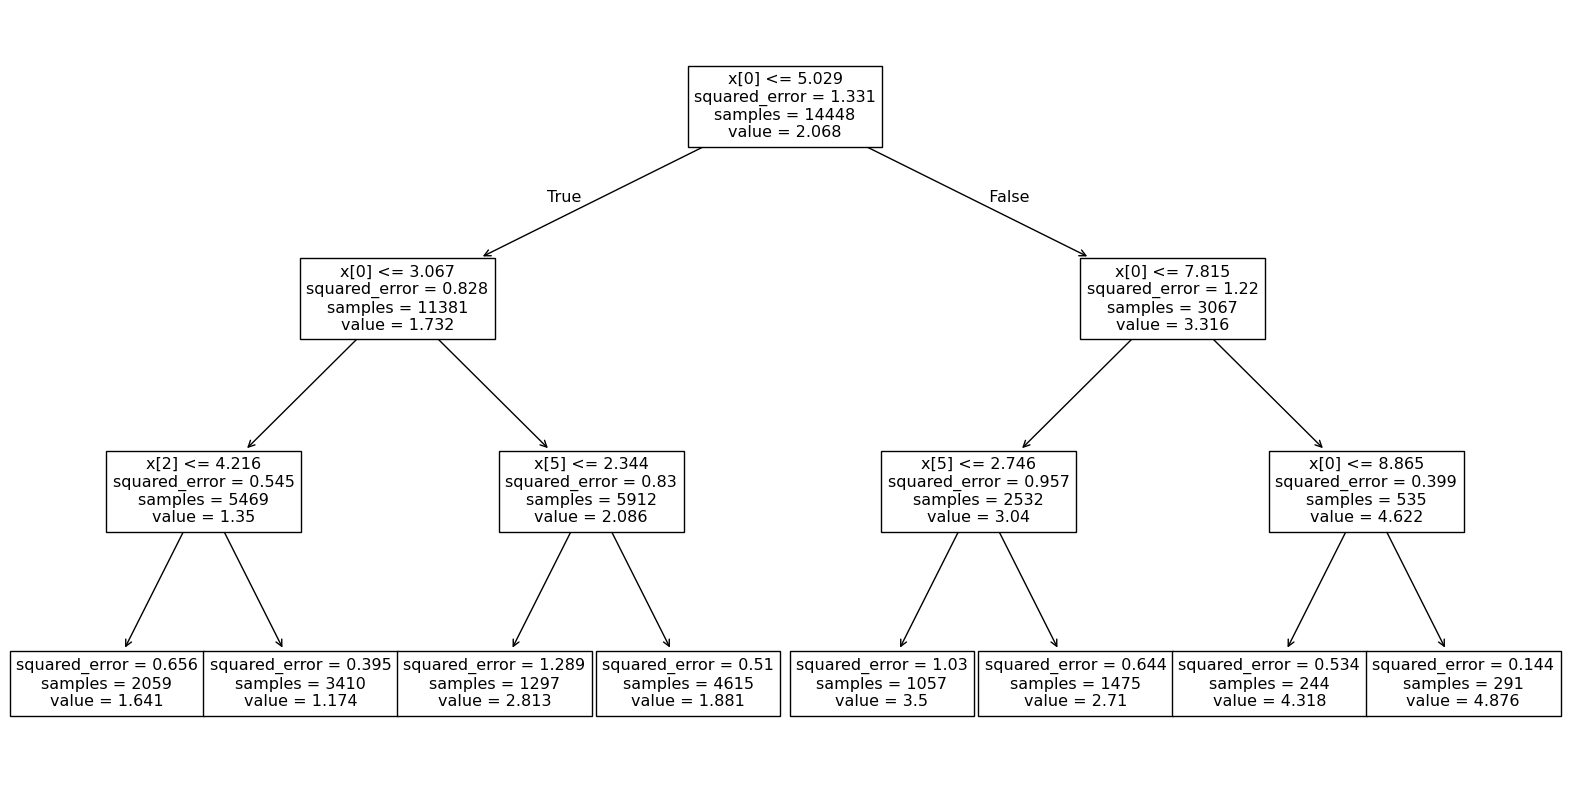

In [ ]:
sklearn_dt_regressor.show_tree()
#sklearn_dt_regressor.show_customized_tree()

### 04 범주형 y변수에 대한 class 정의

In [ ]:
class BinomialClassificationDataLoader:
  def __init__(self, path, feature_names, test_data_ratio, random_state):
    self.data_path = path
    self.feature_names = feature_names
    self.test_data_ratio = test_data_ratio
    self.random_state = random_state

    self.csv_infos = self.get_csv_infos()
    self.csv_data, self.csv_label = self.get_csv_dataset()
    self.train_data, self.train_label, self.test_data, self.test_label = self.get_split_data()

  def __call__(self, flag):
    if flag == 'train':
      return self.train_data, self.train_label
    elif flag == 'test':
      return self.test_data, self.test_label

  def get_csv_infos(self):
    df = pd.read_csv(self.data_path, header=None).drop([0], axis=0)
    df.columns = self.feature_names

    return df

  def get_csv_dataset(self):
    data, label = self.csv_infos[self.feature_names[:-1]], self.csv_infos[self.feature_names[-1]].astype(int)

    return data, label

  def get_split_data(self):
    train_data, test_data, train_label, test_label = model_selection.train_test_split(
        self.csv_data, self.csv_label, test_size=self.test_data_ratio, random_state = self.random_state
    )
    return train_data, train_label, test_data, test_label


classification_dataloader = BinomialClassificationDataLoader(classification_data_path, classification_feature_names, test_data_ratio, random_state)
classification_train_data, classification_train_label = classification_dataloader('train')
classification_test_data, classification_test_label = classification_dataloader('test')

print('classification train data: {}/classification train label: {}'.format(classification_train_data.shape, classification_train_label.shape))
print('classification test data: {}/classification test label: {}'.format(classification_test_data.shape, classification_test_label.shape))

classification train data: (537, 8)/classification train label: (537,)
classification test data: (231, 8)/classification test label: (231,)


### 05 Decision-Tree - 범주

In [ ]:
class SklearnDecisionTreeClassifier:
  def __init__(self, feature_names, max_depth, min_sample_leaf, random_state):
    self.feature_names = feature_names
    self.max_depth = max_depth
    self.min_sample_leaf = min_sample_leaf
    self.random_state = random_state

    self.classifier = tree.DecisionTreeClassifier(
        max_depth=self.max_depth,
        min_samples_leaf=self.min_sample_leaf,
        random_state=self.random_state
    )

  def __call__(self, data):
    return self.classifier.predict(data)

  def train_model(self, train_data, train_label):
      self.classifier.fit(train_data, train_label)

  def test_model(self, test_data, test_label):

    pred = self.classifier.predict(test_data)
    accuracy = accuracy_score(test_label, pred)
    precision = precision_score(test_label, pred)
    recall = recall_score(test_label, pred)
    f1_measure = f1_score(test_label, pred)

    print('acc: {}/precision: {}/recall: {}/f1-measure: {}'.format(accuracy, precision, recall, f1_measure))

  def show_tree(self):
    plt.figure(figsize=(20, 10))
    tree.plot_tree(self.classifier)
    plt.show()

  def show_customized_tree(self):
    dot_data = tree.export_graphviz(
        self.classifier,
        out_file=None,
        feature_names=self.feature_names[:-1],
        class_names = ['0', '1'],
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    graph.view()

sklearn_dt_classifier = SklearnDecisionTreeClassifier(classification_feature_names, max_depth, min_sample_leaf, random_state)
sklearn_dt_classifier.train_model(classification_train_data, classification_train_label)
sklearn_dt_classifier.test_model(classification_test_data, classification_test_label)


acc: 0.7272727272727273/precision: 0.6486486486486487/recall: 0.32432432432432434/f1-measure: 0.43243243243243246
